## Offset GP Regression Model Demonstration

Our data consists of parts of two sine waves, offset a little.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys #TODO: Remove this line
sys.path.append('~/GPy/GPy') #TODO: Remove this line
import GPy
import numpy as np

X1 = np.arange(0,50,1.0)[:,None]
X2 = np.arange(10,60,1.0)[:,None]
X = np.vstack([X1,X2])
ind = np.vstack([np.zeros([50,1]),np.ones([50,1])])
X = np.hstack([X,ind])
Y = np.sin((X[0:50,0])/30.0)[:,None]
Y = np.vstack([Y,Y])

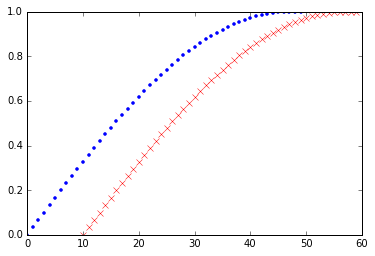

In [2]:
plt.plot(X[X[:,1]==0,0],Y[X[:,1]==0],'.')
plt.plot(X[X[:,1]==1,0],Y[X[:,1]==1],'xr')

Each input is indexed by the last column which specifies which input it is from.

Let's fit our GP to the data...

In [5]:
res = []
m = GPy.models.GPOffsetRegression(X,Y)
#m.offset.set_prior(GPy.priors.Gaussian(60,4))
m.optimize()
m

 /home/lionfish/GPy/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


GP_offset_regression.,value,constraints,priors
rbf.variance,2.3723452523,+ve,
rbf.lengthscale,71.6912613352,+ve,
Gaussian_noise.variance,1.70197659038e-22,+ve,
offset,10.0000001445,,


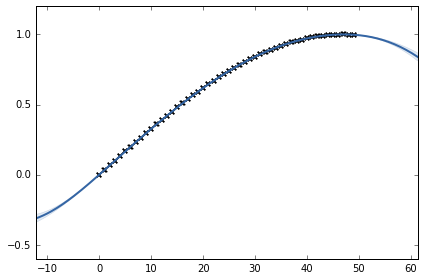

In [33]:
m.plot(fixed_inputs=[(1,0)],legend=None) #fixed the 2nd dimension to zero (0=data, 1=index of timeline)

It's used the offset to align the two datasets, rather than increase the variance.

If we fix the offset at zero and try again, what do we get?

In [34]:
res = []
m = GPy.models.GPOffsetRegression(X,Y)
#m.offset.set_prior(GPy.priors.Gaussian(60,4))
m.offset.fix([0.0])
m.optimize()
m

GP_offset_regression.,value,constraints,priors
rbf.variance,0.373544100222,+ve,
rbf.lengthscale,39.3627437119,+ve,
Gaussian_noise.variance,0.0115181858104,+ve,
offset,0.0,fixed,


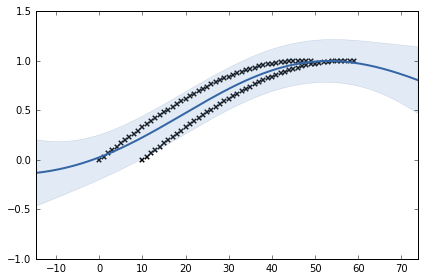

In [35]:
m.plot(fixed_inputs=[(1,0)],legend=None)

It doesn't look as good. It looks like we got a better fit, with the offset.

How's the likelihood vary with the offset? (below I allow GPy to fit everything else).

In [36]:

res = []
m = GPy.models.GPOffsetRegression(X,Y)
for offsettest in range(-100,200,5):
    m.offset.fix([offsettest])
    m.optimize()
    res.append([offsettest,m.log_likelihood()])
    

 /home/lionfish/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


(-100, 100)

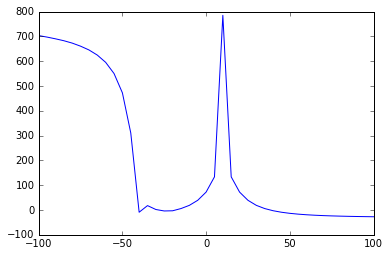

In [37]:
res = np.array(res)
plt.plot(res[:,0],res[:,1])
plt.xlim([-100,100])

Unsurprisingly there's a peak at an offset of 10.

Oddly there's a peak as the offset goes very negative. I think that's because the two sets of points stop 'interfering' and then allow the curve to be quite smooth, with a small variance - and the two sets of data get treated seperately.

I'll need to be careful that I don't let my models do this, and will use Zhenwen's advice re adding a prior to the parameter.

In [40]:
m = GPy.models.GPOffsetRegression(X,Y)
m.offset = -50
m.rbf.lengthscale=1000
#m.offset.fix([-100.0])
m.optimize()
m.offset[0]

10.000001237335768

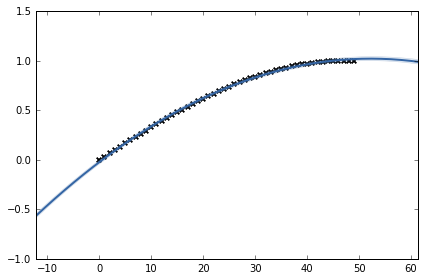

In [41]:
m.plot(fixed_inputs=[(1,0)],legend=None)

In [42]:
X1 = np.arange(0,50,1.0)[:,None]
X2 = np.arange(5,55,1.0)[:,None]
X3 = np.arange(7,57,1.0)[:,None]
X = np.vstack([X1,X2,X3])
ind = np.vstack([np.zeros([50,1]),np.ones([50,1]),np.ones([50,1])*2])
X = np.hstack([X,ind])
Y = np.sin((X[0:50,0])/30.0)[:,None]
Y = np.vstack([Y,Y,Y])

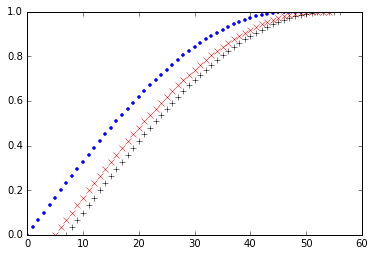

In [43]:
plt.plot(X[X[:,1]==0,0],Y[X[:,1]==0],'.')
plt.plot(X[X[:,1]==1,0],Y[X[:,1]==1],'xr')
plt.plot(X[X[:,1]==2,0],Y[X[:,1]==2],'+k')

In [44]:
m = GPy.models.GPOffsetRegression(X,Y)
#m.offset.set_prior(GPy.priors.Gaussian(60,4))
m.optimize()
m.offset.values

array([ 4.99999954,  6.99999955])

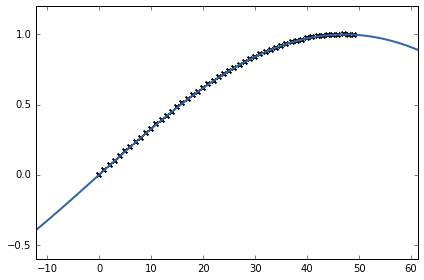

In [45]:
m.plot(fixed_inputs=[(1,0)],legend=None)

# Notes on the kernel

## What is dr_doffset?

We will have a vector $X$ which is used to calculate $r$. We want to know how $r$ changes wrt $\Delta$.

Our input $X_{actual}$ has a block of actual values $X$ and a last column of selectors $s$ (i.e. which cluster it is part of).

    1 0
    3 0
    2 1
    4 1
    4 2
    6 2
    
We have a vector of $\Delta = [2 -1]^\top$ which corresponds to the offset of clusters $1..N$ (so is of length $N-1$).

We know that $r_{ij} = | (X_i - \Delta_{s_i}) - (X_j - \Delta_{s_j}) |$

Let's call the modified $X$, $X'$:

$r_{ij} = | X'_i - X'_j |$

It is important to note that the gradient of the inside of the modulus is;

$\frac{\delta}{\delta \Delta_k} (X_i - X_j) + (\Delta_{s_j} - \Delta_{s_i}) = \begin{cases} +1 &\text{if}\; s_j=k \;\text{and}\; s_i\neq k\\ -1 &\text{if}\; s_i=k \;\text{and}\; s_j\neq k\\ 0 &\text{if neither or both equal k} \end{cases}$

We place all the values of this gradient (for $\Delta_k$) for each pair of $i$ and $j$ into a matrix $G_k$.

If $X_i - X_j < 0$ then the gradient outside the modulus will be in the opposite direction. So we calculate a new matrix $w$, which is the difference between each pair of elements in $X$. We element-wise multiply this by each matrix $G_k$ to get a new matrix which is the gradient of the radius wrt each $\Delta_k$ considering each input pair separately. We element-wise multiply this with the $\frac{dL}{dr}$ matrix (which is calculated as the element-wise product of $\frac{dL}{dr} = \frac{dK}{dr} \times \frac{dL}{dK}$).

We can add together these gradients to find, for each $\Delta_k$ the gradient of the likelihood wrt it.

The result is a new gradient for each offset.

#### Quick check we can cope with situation in which there's only one time series!

Turns out we can't... that's ok.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys #TODO: Remove this line
sys.path.append('~/GPy/GPy') #TODO: Remove this line
import GPy
import numpy as np

X= np.arange(0,50,1.0)[:,None]
ind = np.vstack([np.zeros([50,1])])
X = np.hstack([X,ind])
Y = np.sin((X[0:50,0])/30.0)[:,None]

res = []
m = GPy.models.GPOffsetRegression(X,Y)
#m.offset.set_prior(GPy.priors.Gaussian(60,4))
m.optimize()
m

 /home/lionfish/GPy/GPy/core/gp.py:86: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


IndexError: index 0 is out of bounds for axis 0 with size 0

### Quick check to see what happens if we have multiple outputs

Looks like it tries to go somewhere in between, but it sort of works.

In [4]:
X1 = np.arange(0,50,1.0)[:,None]
X2 = np.arange(10,60,1.0)[:,None]
X = np.vstack([X1,X2])
ind = np.vstack([np.zeros([50,1]),np.ones([50,1])])
X= np.hstack([X,ind])
Y1 = np.hstack([np.sin((0+X[0:50,0])/30.0)[:,None],np.cos((0+X[0:50,0])/30.0)[:,None]])
Y2 = np.hstack([np.sin((1+X[0:50,0])/30.0)[:,None],np.cos((3+X[0:50,0])/30.0)[:,None]])
Y = np.vstack([Y1,Y2])

In [5]:
res = []
m = GPy.models.GPOffsetRegression(X,Y)
#m.offset.set_prior(GPy.priors.Gaussian(60,4))
m.optimize()
m

GP_offset_regression.,value,constraints,priors
rbf.variance,0.828328516798,+ve,
rbf.lengthscale,53.3700575079,+ve,
Gaussian_noise.variance,0.000144829491197,+ve,
offset,7.91511213096,,


(0.5, 1.0)

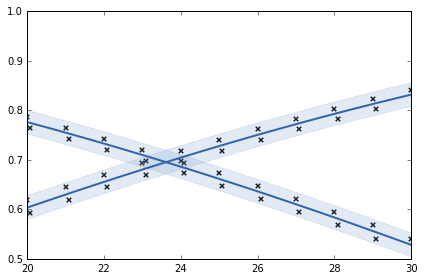

In [63]:
m.plot(fixed_inputs=[(1,0)],legend=None)
plt.xlim([20,30])
plt.ylim([.5,1.0])

In [7]:
m.offset.values[0]

7.9151121309635641

### Check gradients

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys #TODO: Remove this line
sys.path.append('~/GPy/GPy') #TODO: Remove this line
import GPy
import numpy as np

X1 = np.arange(0,50,1.0)[:,None]
X2 = np.arange(10,60,1.0)[:,None]
X = np.vstack([X1,X2])
ind = np.vstack([np.zeros([50,1]),np.ones([50,1])])
X = np.hstack([X,ind])
Y = np.sin((X[0:50,0])/30.0)[:,None]
Y = np.vstack([Y,Y])

In [4]:
res = []
m = GPy.models.GPOffsetRegression(X,Y)
m.checkgrad(verbose=True)

                      Name                       |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------------------------
 GP_offset_regression.rbf.variance               |   1.000000    |   0.000000    |   6.628069    |   6.628069    |     1e-07     
 GP_offset_regression.rbf.lengthscale            |   1.000000    |   0.000000    |   -8.509358   |   -8.509358   |     1e-07     
 GP_offset_regression.Gaussian_noise.variance    |   1.000000    |   0.000000    |   21.559662   |   21.559662   |     4e-07     
 GP_offset_regression.offset                     |   0.999999    |   0.000000    |   -0.275527   |   -0.275526   |     5e-09     


True